In [1]:
# Module Importations
import matplotlib.pylab as plt
import numpy as np
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import tensorflow as tf
import tensorflow.keras as keras
import types
import yellowbrick
from yellowbrick.regressor import PredictionError, ResidualsPlot

# Module Versioning
print('keras version: ', keras.__version__)
print('numpy version: ', np.__version__)
print('sklearn: ' + sklearn.__version__)
print('tensorflow version: ', tf.__version__)
print('yellowbrick: ' + yellowbrick.__version__) 

keras version:  2.4.0
numpy version:  1.19.4
sklearn: 0.22.2.post1
tensorflow version:  2.4.1
yellowbrick: 1.2


In [2]:
# Custom Modules
from Source.Data import ntfp_dataset_import as data_load
from Source.Data import ntfp_split_data as split_data
from Source.Model import ntfp_keras_helpers as keras_helpers
from Source.Model import ntfp_model_evaluation as evaluation
from Source.Model import ntfp_tensorboard_helpers as tb_helpers
from Source.Visualisation import figs_helper

[keras_helpers]Tensorflow version: 2.4.1
[keras_helpers]keras version = 2.4.0


In [3]:
# Module versioning information (WIP)
def yield_version_info():

    # Iterate over items in workspace
    for name, val in globals().items():

        # Try to return version if module type
        if isinstance(val, types.ModuleType):
            try:
                yield val.__name__, val.__version__
            except:
                yield val.__name__, "No version information"

list(yield_version_info())

[('builtins', 'No version information'),
 ('builtins', 'No version information'),
 ('os', 'No version information'),
 ('sys', 'No version information'),
 ('matplotlib.pylab', '1.19.4'),
 ('numpy', '1.19.4'),
 ('sklearn', '0.22.2.post1'),
 ('tensorflow', '2.4.1'),
 ('tensorflow.keras', '2.4.0'),
 ('types', 'No version information'),
 ('yellowbrick', '1.2'),
 ('Source.Data.ntfp_dataset_import', 'No version information'),
 ('Source.Data.ntfp_split_data', 'No version information'),
 ('Source.Model.ntfp_keras_helpers', 'No version information'),
 ('Source.Model.ntfp_model_evaluation', 'No version information'),
 ('Source.Model.ntfp_tensorboard_helpers', 'No version information'),
 ('Source.Visualisation.figs_helper', 'No version information')]

In [4]:
# Constants
SAVE_FIGS = False
TRAIN_BASE_MODEL = True
TRAIN_OPT_MODEL = False

In [5]:
# Load Dataset (Use set from previous ML investigation)
filename = 'rul_dataset_preprocessed.pkl'
rul_df = data_load.load_pickled_data(filename)

print(rul_df)

Loading pickled dataframe started ...
Loading pickled dataframe complete ...
          Sn_04   Sn_07  Sn_11   Sn_12   Sn_15    RUL
Engine                                               
1       1400.60  554.36  47.47  521.66  8.4195 -191.0
1       1403.14  553.75  47.49  522.28  8.4318 -190.0
1       1404.20  554.26  47.27  522.42  8.4178 -189.0
1       1401.87  554.45  47.13  522.86  8.3682 -188.0
1       1406.22  554.00  47.28  522.19  8.4294 -187.0
...         ...     ...    ...     ...     ...    ...
100     1428.63  551.43  48.07  519.49  8.4956   -4.0
100     1433.58  550.86  48.04  519.68  8.5139   -3.0
100     1428.18  550.94  48.09  520.01  8.5646   -2.0
100     1426.53  550.68  48.39  519.67  8.5389   -1.0
100     1432.14  550.79  48.20  519.30  8.5036    0.0

[20631 rows x 6 columns]


In [6]:
# Split data into training and evaluation sets
training_set, evaluation_set = split_data.split_train_eval(rul_df, 0.2)

Original Data Items: 20631
Training Data Items: 16505
Evaluation Data Items: 4126


In [7]:
# Create RUL Target Dataset

# Training Set as Array
rul_training_data = training_set.drop('RUL', axis = 1).values
rul_training_label = training_set['RUL'].copy().values

print(rul_training_data.shape, rul_training_label.shape)

# Evaluation Set as Array
rul_eval_data = evaluation_set.drop('RUL', axis = 1).values
rul_eval_label = evaluation_set['RUL'].copy().values

print(rul_eval_data.shape, rul_eval_label.shape)

(16505, 5) (16505,)
(4126, 5) (4126,)


In [8]:
# Create train and test arrays
X_train, X_test, y_train, y_test = train_test_split(rul_training_data, rul_training_label, test_size = 0.2, random_state = 0)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(13204, 5) (3301, 5)
(13204,) (3301,)


In [9]:
# Initial MLP (Target - RUL)

if TRAIN_BASE_MODEL == True:
    # Clear existing models
    keras.backend.clear_session()

    # Build model
    model = keras_helpers.build_multilayer_perceptron()

    # Name model
    model_type = "MLP_RUL"
    model_id = keras_helpers.name_model(model_type)
    filepath_full = keras_helpers.make_save_string(model_id)

    # Set save and earlystop callbacks
    earlystop_cb = keras.callbacks.EarlyStopping(patience = 5)
    checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath = filepath_full, save_best_only = True)

    # Set TensorBoard callback for logging
    tb_logdir = tb_helpers.get_run_logdir()
    print(tb_logdir)
    tensorboard_cb = keras.callbacks.TensorBoard(tb_logdir)

    # Train model
    model.fit(X_train, y_train, epochs = 20, validation_data =(X_test, y_test), callbacks =[checkpoint_cb, earlystop_cb, tensorboard_cb])

Building Model ...
Hidden Layers: 2, Neurons: 6, LR: 0.001
c:\Developer\nasa-turbofan-failure-prediction\Models\TensorBoard\run_2021_03_16-09_55_54
Epoch 1/20
413/413 [==============================] - 2s 3ms/step - loss: 4929.2628 - val_loss: 4664.6846
Epoch 2/20
413/413 [==============================] - 1s 2ms/step - loss: 4569.7229 - val_loss: 4355.5835
Epoch 3/20
413/413 [==============================] - 1s 1ms/step - loss: 4238.2928 - val_loss: 4493.6812
Epoch 4/20
413/413 [==============================] - 1s 3ms/step - loss: 3825.8647 - val_loss: 3619.1267
Epoch 5/20
413/413 [==============================] - 1s 2ms/step - loss: 3547.6732 - val_loss: 3264.5596
Epoch 6/20
413/413 [==============================] - 1s 2ms/step - loss: 3240.7576 - val_loss: 3042.8315
Epoch 7/20
413/413 [==============================] - 1s 3ms/step - loss: 3033.7902 - val_loss: 3139.5676
Epoch 8/20
413/413 [==============================] - 2s 4ms/step - loss: 2886.6364 - val_loss: 3215.5676
Epoc

In [10]:
# Evaluate MLP Model

if TRAIN_BASE_MODEL == False:
    filepath_full = r'C:\Developer\nasa-turbofan-failure-prediction\Models\PM_MLP_RUL_2021_03_10-10_40_08.h5'

# Load model
model = keras.models.load_model(filepath_full)

# Summarise model
model.summary()

# Make predictions
rul_pred_eval = model.predict(rul_eval_data)

# Determine model prediction stats
model_name = "MLP_RUL"
evaluation.evaluate_model(model_name, rul_eval_label, rul_pred_eval)

# Calculate indicative accuracy
rmse, mae, r2 = evaluation.return_model_evaluation_stats(rul_eval_label, rul_pred_eval)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 36        
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 7         
Total params: 85
Trainable params: 85
Non-trainable params: 0
_________________________________________________________________
MLP_RUL rmse (Eval): 50.01056125147134
MLP_RUL mae (Eval): 40.00408765108794
MLP_RUL r2 (Eval): 0.45253364374984284


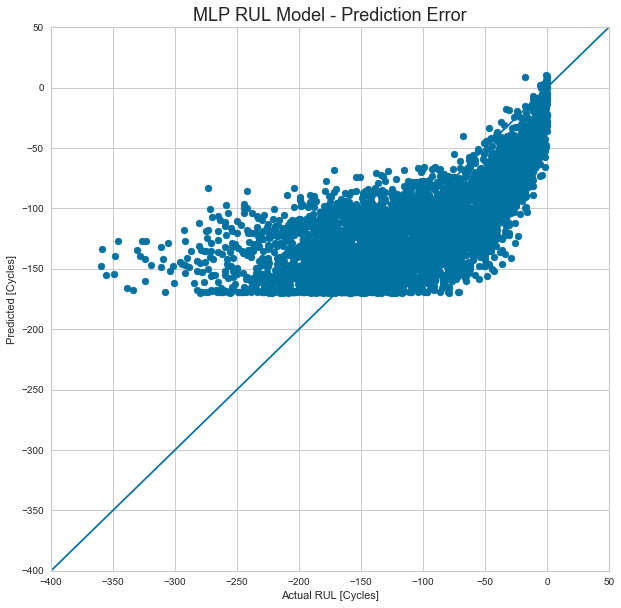

In [11]:
# Visualise Prediction Error (MLP - RUL)
if TRAIN_BASE_MODEL == False:
    filepath_full = r'C:\Developer\nasa-turbofan-failure-prediction\Models\PM_MLP_RUL_2021_03_10-10_40_08.h5'

# Load model
model = keras.models.load_model(filepath_full)
rul_prediction = model.predict(rul_eval_data).flatten()

# Plot predicted and actual data
plt.figure(figsize = (10, 10))
plt.scatter(rul_eval_label, rul_prediction)

# Set figure styling
plt.title('MLP RUL Model - Prediction Error', fontsize = figs_helper.TITLE_FONTSIZE)
plt.xlabel('Actual RUL [Cycles]')
plt.ylabel('Predicted [Cycles]')
lims = [-400, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Save fig
if SAVE_FIGS == True: 
    name = 'MLP_RUL_Prediction_Err'
    save_string = figs_helper.generate_fig_save_string(name)
    plt.savefig(save_string, format = 'png', dpi = 600)

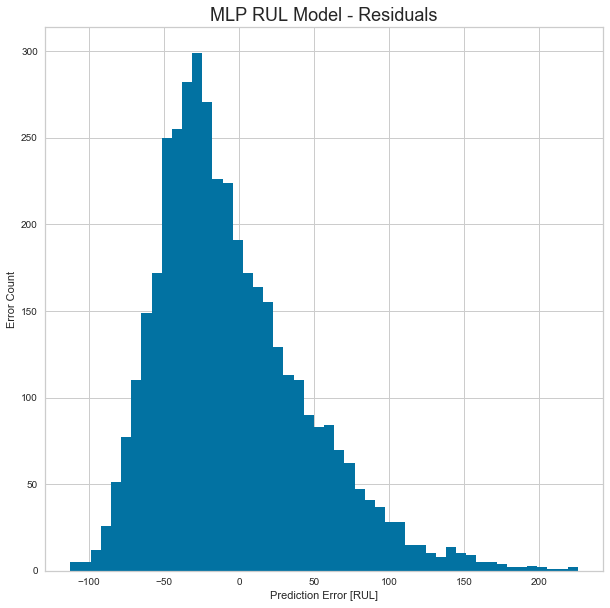

In [12]:
# Visualise Residual Error (MLP - RUL)
if TRAIN_BASE_MODEL == False:
    filepath_full = r'C:\Developer\nasa-turbofan-failure-prediction\Models\PM_MLP_RUL_2021_03_10-10_40_08.h5'

# Load model
model = keras.models.load_model(filepath_full)
error = rul_prediction - rul_eval_label

# Plot predicted and actual data
plt.figure(figsize = (10, 10))
plt.hist(error, bins = 50)

# Set figure styling
plt.title('MLP RUL Model - Residuals', fontsize = figs_helper.TITLE_FONTSIZE)
plt.xlabel('Prediction Error [RUL]')
plt.ylabel('Error Count')

# Save fig
if SAVE_FIGS == True: 
    name = 'MLP_RUL_Residuals'
    save_string = figs_helper.generate_fig_save_string(name)
    plt.savefig(save_string, format = 'png', dpi = 600)

In [13]:
# Optimised MLP (Target - RUL)

if TRAIN_OPT_MODEL == True:
    # Clear existing models
    keras.backend.clear_session()

    # Establish parameter distribution for tuning
    param_distribs = {
        "n_hidden":[2, 4, 8, 16],
        "n_neurons": np.arange(1, 100),
        "learning_rate": [1e-1, 1e-2, 1e-3, 1e-4],
    }

    # Build model
    wrapped_model = keras_helpers.wrap_model()

    # Initialise random search
    rnd_search_cv = RandomizedSearchCV(wrapped_model, param_distribs, n_iter = 10, cv = 3)

    # Name model
    model_type = "MLP_Opt_RUL"
    model_id = keras_helpers.name_model(model_type)
    filepath_full = keras_helpers.make_save_string(model_id)

    # Set save and earlystop callbacks
    earlystop_cb = keras.callbacks.EarlyStopping(patience = 3)
    checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath = filepath_full, save_best_only = True)

    # Set TensorBoard callback for logging
    tb_logdir = tb_helpers.get_run_logdir()
    print(tb_logdir)
    tensorboard_cb = keras.callbacks.TensorBoard(tb_logdir)

    # Train model
    rnd_search_cv.fit(X_train, y_train, epochs = 100, validation_data =(X_test, y_test), callbacks = [checkpoint_cb, earlystop_cb, tensorboard_cb])

In [14]:
# Evaluate MLP Model

if TRAIN_OPT_MODEL == False:
    filepath_full = r'C:\Developer\nasa-turbofan-failure-prediction\Models\PM_MLP_Opt_RUL_2021_03_10-20_41_33.h5'

# Load model
model = keras.models.load_model(filepath_full)

# Summarise model
model.summary()

# Make predictions
rul_pred_eval = model.predict(rul_eval_data)

# Determine model prediction stats
model_name = "MLP_RUL"
evaluation.evaluate_model(model_name, rul_eval_label, rul_pred_eval)

# Calculate indicative accuracy
rmse, mae, r2 = evaluation.return_model_evaluation_stats(rul_eval_label, rul_pred_eval)

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_234 (Dense)            (None, 19)                266       
_________________________________________________________________
dense_235 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_236 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_237 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_238 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_239 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_240 (Dense)            (None, 19)              

ValueError: in user code:

    C:\Developer\Python\Python366\lib\site-packages\tensorflow\python\keras\engine\training.py:1478 predict_function  *
        return step_function(self, iterator)
    C:\Developer\Python\Python366\lib\site-packages\tensorflow\python\keras\engine\training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Developer\Python\Python366\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Developer\Python\Python366\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Developer\Python\Python366\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Developer\Python\Python366\lib\site-packages\tensorflow\python\keras\engine\training.py:1461 run_step  **
        outputs = model.predict_step(data)
    C:\Developer\Python\Python366\lib\site-packages\tensorflow\python\keras\engine\training.py:1434 predict_step
        return self(x, training=False)
    C:\Developer\Python\Python366\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Developer\Python\Python366\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:259 assert_input_compatibility
        ' but received input with shape ' + display_shape(x.shape))

    ValueError: Input 0 of layer sequential_22 is incompatible with the layer: expected axis -1 of input shape to have value 13 but received input with shape (None, 5)


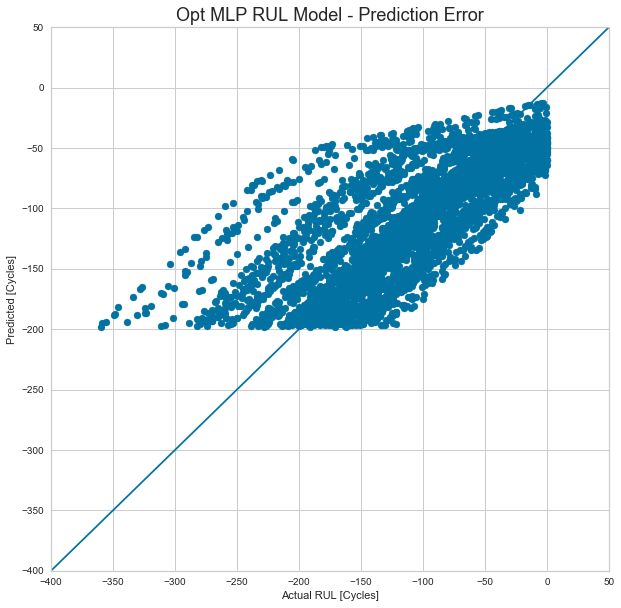

In [15]:
# Visualise Prediction Error (MLP Opt - RUL)
if TRAIN_OPT_MODEL == False:
    filepath_full = r'C:\Developer\nasa-turbofan-failure-prediction\Models\PM_MLP_Opt_RUL_2021_03_10-20_41_33.h5'

# Load model
model = keras.models.load_model(filepath_full)
rul_prediction = model.predict(rul_eval_data).flatten()

# Plot predicted and actual data
plt.figure(figsize = (10, 10))
plt.scatter(rul_eval_label, rul_prediction)

# Set figure styling
plt.title('Opt MLP RUL Model - Prediction Error', fontsize = figs_helper.TITLE_FONTSIZE)
plt.xlabel('Actual RUL [Cycles]')
plt.ylabel('Predicted [Cycles]')
lims = [-400, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Save fig
if SAVE_FIGS == True: 
    name = 'MLP_RUL_Prediction_Err'
    save_string = figs_helper.generate_fig_save_string(name)
    plt.savefig(save_string, format = 'png', dpi = 600)

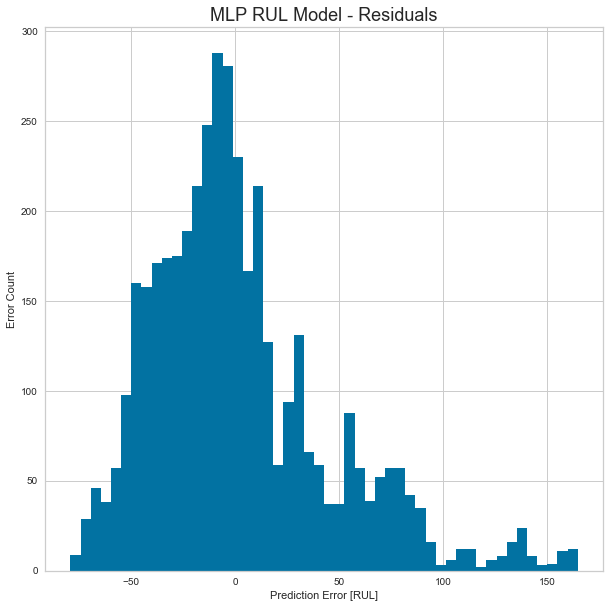

In [16]:
# Visualise Residual Error (MLP - RUL)
if TRAIN_OPT_MODEL == False:
    filepath_full = r'C:\Developer\nasa-turbofan-failure-prediction\Models\PM_MLP_Opt_RUL_2021_03_10-20_41_33.h5'

# Load model
model = keras.models.load_model(filepath_full)
error = rul_prediction - rul_eval_label

# Plot predicted and actual data
plt.figure(figsize = (10, 10))
plt.hist(error, bins = 50)

# Set figure styling
plt.title('MLP RUL Model - Residuals', fontsize = figs_helper.TITLE_FONTSIZE)
plt.xlabel('Prediction Error [RUL]')
plt.ylabel('Error Count')

# Save fig
if SAVE_FIGS == True: 
    name = 'MLP_RUL_Residuals'
    save_string = figs_helper.generate_fig_save_string(name)
    plt.savefig(save_string, format = 'png', dpi = 600)